In [2]:
import math
from numpy import genfromtxt
import numpy as np
import NOCgraph

In [3]:
my_data = genfromtxt('traffic_uniform.csv', delimiter=',')
#check the shape of the dataframe
my_data.shape[0] == my_data.shape[-1]
#get mesh
mesh = math.sqrt(my_data.shape[-1])

In [4]:
class core(): 
    def __init__(self):
        self.Id = 0
        self.Traffic = None
        self.Position = None
        self.Neighbours = []

def dist(a , b):
    d = (a[0] -b[0])**2 + (a[1] -b[1])**2 
    d = math.sqrt(d)
    d = math.ceil(d)
    return d

def traffic_allocation(tr): # Map traffic for each core 
    d = {} 
    #print(x, y, tr)
    for i in range(64):
        d[str(i)] = tr[i]
    return d
        
# Base design Construction
def design(traffic):
    Core_design = list()
    for i in range(64):
        Core_design.append(core())
        Core_design[i].Traffic = traffic_allocation(traffic[i])
        Core_design[i].Id = i
        
    random_design = Core_design    
    for i in range(8):
        for j in range(8):
            random_design[i*8+j].Position = [i,j]
    random_design = links_connection(random_design)
    while not check_links(random_design):
        random_design = design(traffic)
    return random_design
    

#create random links, length <=4
def valid_neighbour_generator(x,y): 
    neighbours = list()
    for i in range(8):
        for j in range(8):
            d = dist([x,y],[i,j]) 
            if (d>0) and (d<=4):
                neighbours.append([i,j])
    return neighbours

def links_connection(design):
    links  = 0
    visited = list()
    i = np.random.choice(range(64))
    while (links < 112):
        if i not in visited:
            visited.append(i)
        else:
            while i in visited:
                i = np.random.choice(range(64))
        if len(visited)> 60:
            visited = []
        links = link_per_core(design,i,links)
    
    return design

def link_per_core(design,position,links):  # links are connected for each core and constrained has been maintained as total links112
    link_count  = 7
    p_x,p_y  =  design[position].Position
    valid_neighbours = valid_neighbour_generator(p_x, p_y)
    np.random.shuffle(valid_neighbours)
    ind =0
    while True:
        if len(design[position].Neighbours)>= link_count:
            return links
        x,y = valid_neighbours[ind]
        c  = core_location(design,[x,y])
        if (len(c.Neighbours)< link_count):
            if ([x,y] not in design[position].Neighbours) and ([p_x,p_y] not in c.Neighbours):
                if links < 112:
                    d= dist([p_x,p_y], [x,y])
                    if d<4:
                        design[position].Neighbours.append([x,y])
                        c.Neighbours.append([p_x,p_y])
                        links+=1
                else:
                    return links 
        if np.random.choice([0,1]):  # randomization added for links.
                return links
        ind = ind+ 1
        if ind >=  len(valid_neighbours):
            return links
    
def check_links(design):
    for i in range(64):   
            if len(design[i].Neighbours) == 0:
                return 0
            if len(design[i].Neighbours) > 7:
                return 0
    return 1

def core_location(design , v_pos):
    for i in design:
        if i.Position == v_pos:
            return i
    print("Unknown core")

In [5]:
#function plot NOC graph
import matplotlib.pyplot as plt

def display_NOC(design):
    for i in range(8):
        for j in range(8):
            #plot core placements
            plt.plot(i,j ,'x')
            #plot links
            for k in design[i*8+j].Neighbours:
                plt.plot([k[0],design[i*8+j].Position[0]],[k[1],design[i*8+j].Position[1]],'o-') 
    plt.grid()
    plt.show()

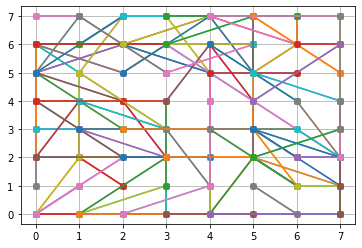

In [6]:
new_design = design(my_data)
display_NOC(new_design)

In [8]:
#link placement: adjacency matrix & task placement: vector for task placement 
def task_placement(design):
    core_matrix = np.zeros((64))
    for i in range(64):
        core_matrix[design[i].Id] = int(design[i].Position[0]*8+design[i].Position[1])
    core_matrix = core_matrix.reshape(1,64)    
    return core_matrix
       
def link_placement(design):
    core_links = np.zeros((64,64))
    for i in range(64):
         core_links[i] = adjacency(design[i])
    #core_links = core_links.reshape(1,4096)        
    return core_links

def adjacency(c):
    line=np.zeros(64)
    for n in c.Neighbours:
        adj = n[0]*8 +n[1]
        line[adj] = 1
    return line

In [9]:
a = link_placement(new_design)
a

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
#dijkstra shortest path algorithm
import queue  

def dijkstra(graph, source, dest):  
    q = queue.PriorityQueue()
    parents = []
    distances = []
    start_weight = float("inf")

    for i in graph.get_vertex():
        weight = start_weight
        if source == i:
            weight = 0
        distances.append(weight)
        parents.append(None)

    q.put(([0, source]))

    while not q.empty():
        v_tuple = q.get()
        v = v_tuple[1]

        for e in graph.get_edge(v):
            candidate_distance = distances[v] + e.weight
            if distances[e.vertex] > candidate_distance:
                distances[e.vertex] = candidate_distance
                parents[e.vertex] = v
                # primitive but effective negative cycle detection
                if candidate_distance < -1000:
                    raise Exception("Negative cycle detected")
                q.put(([distances[e.vertex], e.vertex]))

    shortest_path = []
    end = dest
    while end is not None:
        shortest_path.append(end)
        end = parents[end]

    shortest_path.reverse()
    if len(shortest_path)-1 == 0:
        return 'invalid'
    return len(shortest_path)-1
   

In [11]:
def cost_per_core(design,graph,s):
    hop_count=0
    traffic_wtd_count = 0
    for de in range(64):
        src_id = design[s].Id
        d_id =  design[de].Id
        if s != de:
            hop_count = dijkstra(graph,src_id,d_id)
            if hop_count == 'invalid':
                return 'invalid'
            else:
                traffic = design[s].Traffic[str(d_id)]
                traffic_wtd_count += (hop_count * traffic)
    return traffic_wtd_count

def get_cost(design,wt_graph):
    cost = 0
    for cores in range(64):
        weight = cost_per_core(design,wt_graph,cores)
        if weight == 'invalid':
            print('Not a valid design')
            return 'invalid'
        else:
            cost+= weight
    return cost

In [13]:
new_graph = NOCgraph.create_graph(new_design)

In [14]:
#original trafffic weighted zero load latency
get_cost(new_design,new_graph)

8596.112898349664

In [12]:
import copy

def cores_swap(curr,nxt):
    curr.Position,nxt.Position = nxt.Position,curr.Position
    curr.Neighbours,nxt.Neighbours = nxt.Neighbours,curr.Neighbours

def change_core(design):
    curr =  design[np.random.choice(range(64))]
    nxt = design[np.random.choice(range(64))]
    cores_swap(curr,nxt)
    return design

def random_change(d):
    design = copy.deepcopy(d)
    if np.random.choice([1,0]):
        design = change_core(design)
    else:
        design = change_link(design)
    if not check_links(design):
        design = d
    return design

def random_NOC_generator():# Function to create a random design
    new_design  = copy.deepcopy(Core_design)
    for i in range(8):
        for j in range(8):
            new_design[i*8+j].Position = [i,j]
    new_design = links_connection(new_design)
    while not check_links(new_design):
        new_design = random_NOC_generator()
    return new_design

def change_link(design):
    x = np.random.choice(range(64))
    curr = design[x]
    v_neighbours  = valid_neighbour_generator(curr.Position[0],curr.Position[1])
    link  = v_neighbours[np.random.choice(range(len(v_neighbours)))]
    n = core_location(design,link) 
    while (link in curr.Neighbours) and len(n.Neighbours) == 7 :
        link  = v_neighbours[np.random.choice(range(len(v_neighbours)))]
    curr.Neighbours = curr.Neighbours[:-1]
    curr.Neighbours.append(link)
    n.Neighbours.append(curr.Position)
    return design

In [13]:
import random

def simulated_annealing(design):
    print("Simulation starts")
    current = design
    g_current =NOCgraph.create_graph(current)
    current_cost = get_cost(current, g_current)
    T = 100
    Tth = 0.1
    a = 0.99
    while T> Tth:
        numi = 0
        while numi<20:
            nxt_design = random_change(current)
            graph_nxt = NOCgraph.create_graph(nxt_design)
            nxt_cost = get_cost(nxt_design,graph_nxt)
            if nxt_cost != 'invalid':
                acc_probab = np.exp((-nxt_cost-current_cost)/T)
                if nxt_cost< current_cost:
                    current = nxt_design
                    current_cost = nxt_cost
                else:    
                    if acc_probab > random.uniform(0,1):
                        current = nxt_design
                        current_cost = nxt_cost     
            numi +=1
        T = T*a
   
    return current, current_cost

In [14]:
new_design = design(my_data)

In [15]:
best_uniform, cost_uniform = simulated_annealing(new_design)

Simulation starts


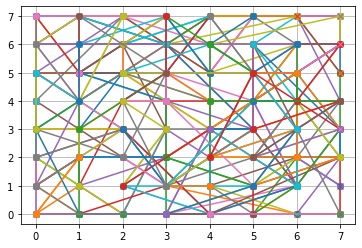

In [16]:
display_NOC(best_uniform)

In [43]:
t_uni = task_placement(best_uniform)
l_uni = link_placement(best_uniform)
import pandas
l_adj = pandas.DataFrame(l_uni,columns=t_uni[0], index=t_uni[0])
l_adj

,49.0,0.0,18.0,3.0,57.0,24.0,5.0,42.0,9.0,14.0,...,35.0,25.0,15.0,29.0,51.0,52.0,12.0,60.0,45.0,20.0
49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
12.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
t_uni[0]

array([49.,  0., 18.,  3., 57., 24.,  5., 42.,  9., 14., 11., 19., 54.,
       43., 16., 47., 36., 61., 46., 50., 37.,  1., 13., 23., 44., 53.,
       17., 48., 55., 33., 27., 26.,  4., 34.,  2., 21., 58.,  8., 63.,
       32., 41., 30., 40., 39., 56., 22., 10., 62., 59., 38.,  7., 31.,
        6., 28., 35., 25., 15., 29., 51., 52., 12., 60., 45., 20.])

In [24]:
cost_uniform

4283.280548990766

In [25]:
#load file traffic_random
traffic_rand = genfromtxt('traffic_rand.csv', delimiter=',')

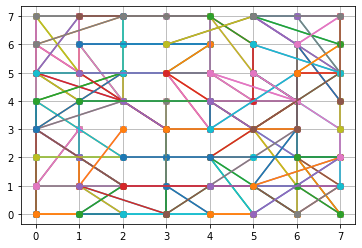

In [26]:
design_rand = design(traffic_rand)
display_NOC(design_rand)

In [27]:
graph_rand = NOCgraph.create_graph(design_rand)
get_cost(design_rand,graph_rand)

7711.38961102337

In [28]:
best_rand, cost_rand = simulated_annealing(design_rand)

Simulation starts


In [29]:
min(c_rand)

5336.587891636251

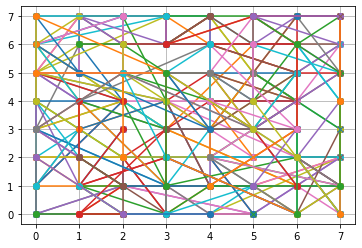

In [38]:
display_NOC(best_rand)

In [40]:
t_rand = task_placement(best_rand)
l_rand = link_placement(new_design)
import pandas
l_adj = pandas.DataFrame(l_rand,columns=t_rand[0], index=t_rand[0])
l_adj

,24.0,46.0,50.0,26.0,37.0,32.0,17.0,58.0,53.0,62.0,...,7.0,43.0,51.0,60.0,21.0,47.0,16.0,44.0,63.0,29.0
24.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [41]:
t_rand[0]

array([24., 46., 50., 26., 37., 32., 17., 58., 53., 62., 36., 42., 45.,
       13., 40.,  0., 49., 33., 20., 14., 23.,  1., 52., 18., 31., 39.,
        8.,  9., 34., 12., 28., 54., 27.,  4., 59.,  2.,  3., 15., 25.,
       35., 19., 41., 57., 11., 55., 48.,  5., 38., 22.,  6., 61., 10.,
       56., 30.,  7., 43., 51., 60., 21., 47., 16., 44., 63., 29.])

In [31]:
#load file traffic_complement
traffic_comp = genfromtxt('traffic_complement.csv', delimiter=',')

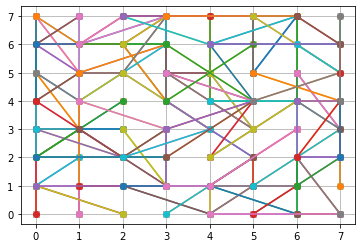

In [32]:
design_comp = design(traffic_comp)
display_NOC(design_comp)

In [33]:
graph_comp = NOCgraph.create_graph(design_comp)
get_cost(design_comp,graph_comp)

1743.8261411340284

In [34]:
best_comp, cost_comp = simulated_annealing(design_comp)

Simulation starts


In [42]:
cost_comp

1151.4257024720764

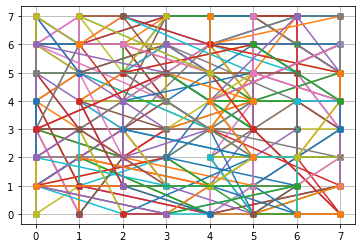

In [37]:
display_NOC(best_comp)

In [139]:
t_comp = task_placement(best_comp)
l_comp = link_placement(new_design)
import pandas
l_comp_adj = pandas.DataFrame(l_rand,columns=t_comp[0], index=t_comp[0])
l_comp_adj

,43.0,27.0,15.0,25.0,29.0,17.0,47.0,22.0,16.0,3.0,...,11.0,0.0,39.0,46.0,9.0,19.0,32.0,7.0,1.0,40.0
43.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [140]:
t_comp[0]

array([43., 27., 15., 25., 29., 17., 47., 22., 16.,  3., 51., 10., 28.,
       62., 56., 53., 34.,  4., 48., 63., 61.,  6., 13., 18., 59., 14.,
       44., 31., 24., 41., 30., 58., 42., 23., 33., 26., 38., 50., 20.,
       60.,  8., 21.,  5., 45., 55., 57., 12., 35., 37., 49., 54., 36.,
        2., 52., 11.,  0., 39., 46.,  9., 19., 32.,  7.,  1., 40.])